KABAM Assignment (Data Scientist Position)

In [1]:
import numpy as np
import pandas as pd
from sqlite3 import connect
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Bidirectional, Embedding, RepeatVector, TimeDistributed, Flatten
import time
import keras
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV, LassoLarsCV, Lasso, LassoCV, RidgeCV, Ridge, LarsCV, ElasticNet
from keras.callbacks import Callback
from keras.models import load_model
import lazypredict
from lazypredict.Supervised import LazyClassifier
from lazypredict.Supervised import LazyRegressor
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

C:\Users\terak\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Parameters

# Two approaches: classification or Regression. Just one should be True
classification_mode = True
regression_mode = False

# Undersampling can be False, "not minority", or integer. between 0 and 1.
# 0.5 indicates majority class is double than minority.
down_sample = 0.1
# oversampling can be False, 'random_oversample' or 'smote_oversample'
up_sample = 'smote_oversample'
# number of classes for classification. 2, 3 or 5 classes for now.
n_class = 2

if classification_mode:
    # int as n_components for PCA or False for no PCA
    PCA_apply = False
    # drop categorical columns
    drop_categorical_cols = False
    # if True then label with value of 0 will be removed
    drop_zero_calss = False

if regression_mode:
    # int as n_components for PCA or False for no PCA
    PCA_apply = 10
    # drop categorical columns
    drop_categorical_cols = True
    # if True then label with value of 0 will be removed
    drop_zero_calss = True

start = time.time()

In [3]:
def df_index(df, index, droped_columns): 
    """
    This function takes a dataframe and returns a new dataframe with the specified index
    and remove droped columns.

    Parameters:
    -----------
    df: pandas dataframe
        The dataframe to be indexed.
    index: string
        The name of the index column.
    droped_columns: list of strings
        The list of columns to be dropped.

    Returns: pandas dataframe
    """
    df.index = df[index]
    df.drop(columns=droped_columns, inplace=True)
    return df

Load Data

In [4]:
# Load ka_actions as dataframe
# place datasets into kabam_ds_interview folder or change the path
ka_actions = pd.read_parquet('./kabam_ds_interview/ka_actions.parquet')
ka_actions = df_index(ka_actions, 'uid_s', ['uid_s'])
print(ka_actions.shape)
print("Number of Nans for each column: \n",ka_actions.isna().sum())
ka_actions.head()

(2845931, 9)
Number of Nans for each column: 
 logins                                    37
game_stats_tutorial_complete         1088934
game_stats_tutorial_complete_time    1094183
game_stats_xp                         762888
game_stats_xp1                        762888
game_stats_xp2                        762888
game_stats_xp3                        762888
redeemer_actions                       10282
scribe_actions                             1
dtype: int64


,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions
uid_s,,,,,,,,,
0,7.00,1.00,470000000.00,1693.00,592.00,0.00,429.00,446.00,364.00
1,2.00,1.00,612000000.00,197.00,197.00,0.00,0.00,60.00,125.00
2,2.00,1.00,390000000.00,313.00,313.00,0.00,0.00,89.00,129.00
3,3.00,1.00,661000000.00,1319.00,1319.00,0.00,0.00,275.00,200.00
4,4.00,1.00,3147000000.00,148.00,148.00,0.00,0.00,58.00,138.00


In [5]:
# Load ka_users as dataframe
ka_users = pd.read_csv('./kabam_ds_interview/ka_users.csv')
ka_users = df_index(ka_users, 'uid_s', ['uid_s'])
print(ka_users.shape)
print("Number of Nans for each column: \n", ka_users.isna().sum())
ka_users.head()

(2845931, 7)
Number of Nans for each column: 
 lang_s                    0
geo_s                   126
region_s                  0
tz_i                      0
local_time_join_hour      0
local_time_join_dow       0
total_spend               0
dtype: int64


,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,total_spend
uid_s,,,,,,,
0,EN,MY,asia,28800,14,3,0
1,ES,MX,americas,-18000,14,1,0
2,ZH-CN,CN,asia,28800,2,3,0
3,ZH-CN,CN,asia,28800,8,6,0
4,EN,IN,asia,19800,19,6,0


In [6]:
# Chech the name of the tables in ka_devices database.
ka_devices_db = connect('./kabam_ds_interview/ka_devices.db')
ka_devices_name = pd.read_sql_query("SELECT name as table_name FROM sqlite_schema WHERE type ='table' AND name NOT LIKE 'sqlite_%';", ka_devices_db)
ka_devices_name

,table_name
0,devices


In [7]:
# Load ka_devices as dataframe
ka_devices = pd.read_sql_query("SELECT * FROM devices", ka_devices_db)
ka_devices = df_index(ka_devices, 'uid_s', ['uid_s', 'index'])
print(ka_devices.shape)
print("Number of Nans for each column: \n", ka_devices.isna().sum())
ka_devices.head()

(2845931, 12)
Number of Nans for each column: 
 platform_s                0
device_mapped_s           6
device_manufacturer_s     6
device_mem_i              1
device_gmem_i             1
device_mem_grouping_i     1
device_gmem_grouping_i    1
device_numcpu_i           1
device_height_i           1
device_gpu_s              1
device_os_s               1
device_model_s            6
dtype: int64


,platform_s,device_mapped_s,device_manufacturer_s,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i,device_gpu_s,device_os_s,device_model_s
uid_s,,,,,,,,,,,,
0,android,asus_x01ad,asus,3575.00,1024.00,3584.00,1024.00,8.00,720.00,adreno (tm) 506,android os 9 / api-28 (ww_phone-201905061022/1...,asus_x01ad
1,android,moto g (5),motorola,1867.00,512.00,1920.00,512.00,8.00,1080.00,adreno (tm) 505,android os 8.1.0 / api-27 (opps28.85-13-6/04442),moto g (5)
2,android,mi 6,xiaomi,3726.00,1024.00,3776.00,1024.00,8.00,1080.00,adreno (tm) 540,android os 8.0.0 / api-26 (opr1.170623.027/v10...,mi 6
3,android,oppo r7splus,oppo,3629.00,1024.00,3648.00,1024.00,8.00,1080.00,adreno (tm) 405,android os 5.1.1 / api-22 (lmy47v/eng.root.201...,oppo r7splus
4,android,cph1803,oppo,2816.00,1024.00,2816.00,1024.00,8.00,720.00,adreno (tm) 506,android os 8.1.0 / api-27 (opm1.171019.026/155...,cph1803


In [8]:
# Describe all dataframes
for df in [ka_devices, ka_actions, ka_users]:
    print(f"Describe dataframe: \n", df.describe())
    print(df.shape)
    print("********"*12)

Describe dataframe: 
        device_mem_i  device_gmem_i  device_mem_grouping_i  \
count    2845930.00     2845930.00             2845930.00   
mean        2668.95         818.02                2701.93   
std         2870.86         521.69                2871.44   
min          341.00         128.00                 384.00   
25%         1822.00         512.00                1856.00   
50%         2753.00        1024.00                2816.00   
75%         3595.00        1024.00                3648.00   
max      4148139.00      262144.00             4148160.00   

       device_gmem_grouping_i  device_numcpu_i  device_height_i  
count              2845930.00       2845930.00       2845930.00  
mean                   818.02             5.81           890.85  
std                    521.69             2.43           254.87  
min                    128.00             1.00           240.00  
25%                    512.00             4.00           720.00  
50%                   1024.00   

In [9]:
# Join all dataframes to have one dataframe with all data
df = ka_users.join(ka_devices, on=ka_users.index).join(ka_actions, on=ka_actions.index)
print(df.columns)
# print((df[df['total_spend']>0].shape[0] / df[df['total_spend']==0].shape[0])*100)
df

Index(['lang_s', 'geo_s', 'region_s', 'tz_i', 'local_time_join_hour',
       'local_time_join_dow', 'total_spend', 'platform_s', 'device_mapped_s',
       'device_manufacturer_s', 'device_mem_i', 'device_gmem_i',
       'device_mem_grouping_i', 'device_gmem_grouping_i', 'device_numcpu_i',
       'device_height_i', 'device_gpu_s', 'device_os_s', 'device_model_s',
       'logins', 'game_stats_tutorial_complete',
       'game_stats_tutorial_complete_time', 'game_stats_xp', 'game_stats_xp1',
       'game_stats_xp2', 'game_stats_xp3', 'redeemer_actions',
       'scribe_actions'],
      dtype='object')


,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,total_spend,platform_s,device_mapped_s,device_manufacturer_s,...,device_model_s,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions
uid_s,,,,,,,,,,,,,,,,,,,,,
0,EN,MY,asia,28800,14,3,0,android,asus_x01ad,asus,...,asus_x01ad,7.00,1.00,470000000.00,1693.00,592.00,0.00,429.00,446.00,364.00
1,ES,MX,americas,-18000,14,1,0,android,moto g (5),motorola,...,moto g (5),2.00,1.00,612000000.00,197.00,197.00,0.00,0.00,60.00,125.00
2,ZH-CN,CN,asia,28800,2,3,0,android,mi 6,xiaomi,...,mi 6,2.00,1.00,390000000.00,313.00,313.00,0.00,0.00,89.00,129.00
3,ZH-CN,CN,asia,28800,8,6,0,android,oppo r7splus,oppo,...,oppo r7splus,3.00,1.00,661000000.00,1319.00,1319.00,0.00,0.00,275.00,200.00
4,EN,IN,asia,19800,19,6,0,android,cph1803,oppo,...,cph1803,4.00,1.00,3147000000.00,148.00,148.00,0.00,0.00,58.00,138.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845926,KO,KR,asia,32400,17,5,0,android,sm-n920s,samsung,...,sm-n920s,2.00,1.00,1391000000.00,80.00,80.00,0.00,0.00,43.00,132.00
2845927,EN,SA,asia,10800,11,5,0,iphone,iphone 6,apple,...,"iphone7,2",2.00,1.00,1000000000.00,148.00,148.00,0.00,0.00,59.00,136.00
2845928,EN,IN,asia,19800,13,5,0,android,lenovo pb2-650m,lenovo,...,lenovo pb2-650m,2.00,nan,nan,nan,nan,nan,nan,21.00,51.00


In [10]:
# how many of each value for game_stats_tutorial_complete
unique_game_stats_tutorial_complete = df.game_stats_tutorial_complete.unique()
print(unique_game_stats_tutorial_complete)

print(f"Number of game_stats_tutorial_complete with value of 1: ",
                                df[df.game_stats_tutorial_complete == 1.].shape[0])
print(f"Number of game_stats_tutorial_complete with value of 0: ",
                                df[df.game_stats_tutorial_complete == 0.].shape[0])
print(f"Number of game_stats_tutorial_complete with value of Nan: ",
                                df.game_stats_tutorial_complete.isna().sum())

[ 1. nan  0.]
Number of game_stats_tutorial_complete with value of 1:  1751748
Number of game_stats_tutorial_complete with value of 0:  5249
Number of game_stats_tutorial_complete with value of Nan:  1088934


In [11]:
experiences = [col for col in df if col.startswith('game_stats_xp')]
for exp in experiences:
    print(f"Number of {exp} with value of Nan: ",
                                df[df[exp].isna()].shape[0])

Number of game_stats_xp with value of Nan:  762888
Number of game_stats_xp1 with value of Nan:  762888
Number of game_stats_xp2 with value of Nan:  762888
Number of game_stats_xp3 with value of Nan:  762888


Preprocessing

In [12]:
# create and describe dataframe with only tutorial complete is 1,
# since we are just interested in people who finished tutorial
df_completed_tutorial = df[df.game_stats_tutorial_complete == 1.]
df_completed_tutorial.describe()

,tz_i,local_time_join_hour,local_time_join_dow,total_spend,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions
count,1751748.00,1751748.00,1751748.00,1751748.00,1751747.00,1751747.00,1751747.00,1751747.00,1751747.00,1751747.00,1751736.00,1751748.00,1751748.00,1751685.00,1751685.00,1751685.00,1751685.00,1751748.00,1751748.00
mean,11717.19,14.59,4.22,1.87,2803.50,861.08,2836.77,861.08,5.94,910.50,3.21,1.00,1750700086.43,1047.15,514.85,153.07,93.84,199.49,184.60
std,19285.13,5.58,2.34,17.14,3489.62,553.21,3489.98,553.21,2.44,254.99,2.58,0.00,3818346144.06,2660.38,606.22,621.68,545.98,270.22,81.14
min,-39600.00,0.00,1.00,0.00,382.00,128.00,384.00,128.00,1.00,240.00,1.00,1.00,228000000.00,5.00,0.00,0.00,0.00,1.00,104.00
25%,-10800.00,11.00,2.00,0.00,1858.00,512.00,1920.00,512.00,4.00,720.00,2.00,1.00,508000000.00,192.00,137.00,0.00,0.00,61.00,132.00
50%,19800.00,15.00,4.00,0.00,2810.00,1024.00,2816.00,1024.00,8.00,810.00,3.00,1.00,637000000.00,317.00,313.00,0.00,0.00,102.00,154.00
75%,28800.00,19.00,7.00,0.00,3644.00,1024.00,3648.00,1024.00,8.00,1080.00,4.00,1.00,943000000.00,1023.00,607.00,0.00,0.00,219.00,205.00
max,39600.00,23.00,7.00,450.00,4148139.00,262144.00,4148160.00,262144.00,32.00,2960.00,523.00,1.00,28800000000.00,340095.00,36952.00,46048.00,46973.00,9078.00,3782.00


In [13]:
print(df.total_spend.describe())
print(df_completed_tutorial.total_spend.describe())

count   2845931.00
mean          1.22
std          13.86
min           0.00
25%           0.00
50%           0.00
75%           0.00
max         450.00
Name: total_spend, dtype: float64
count   1751748.00
mean          1.87
std          17.14
min           0.00
25%           0.00
50%           0.00
75%           0.00
max         450.00
Name: total_spend, dtype: float64


In [14]:
# plt.figure(figsize=(20, 8))
# plt.title('Total spend')
# plt.ylabel('Total spend')
# plt.bar(np.arange(0,df_completed_tutorial.shape[0]), df_completed_tutorial['total_spend'].values)

In [15]:
# df_completed_tutorial.plot(x='total_spend', y=['game_stats_xp', 'game_stats_xp1',
#        'game_stats_xp2', 'game_stats_xp3',], kind="bar")

In [16]:
# Drop duplicates from dataframe
df_completed_tutorial.drop_duplicates(inplace=True)
df_completed_tutorial

,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,total_spend,platform_s,device_mapped_s,device_manufacturer_s,...,device_model_s,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions
uid_s,,,,,,,,,,,,,,,,,,,,,
0,EN,MY,asia,28800,14,3,0,android,asus_x01ad,asus,...,asus_x01ad,7.00,1.00,470000000.00,1693.00,592.00,0.00,429.00,446.00,364.00
1,ES,MX,americas,-18000,14,1,0,android,moto g (5),motorola,...,moto g (5),2.00,1.00,612000000.00,197.00,197.00,0.00,0.00,60.00,125.00
2,ZH-CN,CN,asia,28800,2,3,0,android,mi 6,xiaomi,...,mi 6,2.00,1.00,390000000.00,313.00,313.00,0.00,0.00,89.00,129.00
3,ZH-CN,CN,asia,28800,8,6,0,android,oppo r7splus,oppo,...,oppo r7splus,3.00,1.00,661000000.00,1319.00,1319.00,0.00,0.00,275.00,200.00
4,EN,IN,asia,19800,19,6,0,android,cph1803,oppo,...,cph1803,4.00,1.00,3147000000.00,148.00,148.00,0.00,0.00,58.00,138.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845925,EN,DE,europe,7200,10,5,0,iphone,iphone 6,apple,...,"iphone7,2",2.00,1.00,732000000.00,138.00,138.00,0.00,0.00,52.00,123.00
2845926,KO,KR,asia,32400,17,5,0,android,sm-n920s,samsung,...,sm-n920s,2.00,1.00,1391000000.00,80.00,80.00,0.00,0.00,43.00,132.00
2845927,EN,SA,asia,10800,11,5,0,iphone,iphone 6,apple,...,"iphone7,2",2.00,1.00,1000000000.00,148.00,148.00,0.00,0.00,59.00,136.00


In [17]:
# Drop Nan values from dataframe
print("Number of Nans for each column just with completed tutorial: \n", df_completed_tutorial.isna().sum())
df_completed_tutorial.dropna(inplace=True)
print("Number of Nans for each column just with completed tutorial: \n", df_completed_tutorial.isna().sum())
# df_completed_tutorial.to_csv('./kabam_ds_interview/df.csv')

Number of Nans for each column just with completed tutorial: 
 lang_s                                0
geo_s                                66
region_s                              0
tz_i                                  0
local_time_join_hour                  0
local_time_join_dow                   0
total_spend                           0
platform_s                            0
device_mapped_s                       4
device_manufacturer_s                 2
device_mem_i                          1
device_gmem_i                         1
device_mem_grouping_i                 1
device_gmem_grouping_i                1
device_numcpu_i                       1
device_height_i                       1
device_gpu_s                          1
device_os_s                           1
device_model_s                        4
logins                               12
game_stats_tutorial_complete          0
game_stats_tutorial_complete_time     0
game_stats_xp                        63
game_stats_xp1   

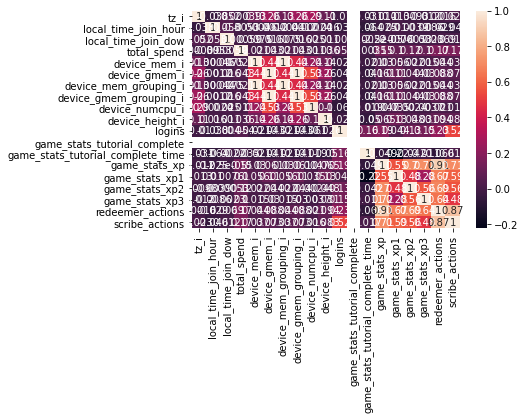

In [18]:
# Correlation matrix
corrMatrix = df_completed_tutorial.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [19]:
# Very correated features like device_mem_i can be removed.
print((corrMatrix>0.9).sum())
# df_completed_tutorial.drop(columns=['device_mem_i', 'device_gmem_i',
#                                     'device_mem_grouping_i', 'device_gmem_grouping_i'], inplace=True)
df_completed_tutorial.columns

tz_i                                 1
local_time_join_hour                 1
local_time_join_dow                  1
total_spend                          1
device_mem_i                         2
device_gmem_i                        2
device_mem_grouping_i                2
device_gmem_grouping_i               2
device_numcpu_i                      1
device_height_i                      1
logins                               1
game_stats_tutorial_complete         0
game_stats_tutorial_complete_time    1
game_stats_xp                        2
game_stats_xp1                       1
game_stats_xp2                       1
game_stats_xp3                       1
redeemer_actions                     2
scribe_actions                       1
dtype: int64


Index(['lang_s', 'geo_s', 'region_s', 'tz_i', 'local_time_join_hour',
       'local_time_join_dow', 'total_spend', 'platform_s', 'device_mapped_s',
       'device_manufacturer_s', 'device_mem_i', 'device_gmem_i',
       'device_mem_grouping_i', 'device_gmem_grouping_i', 'device_numcpu_i',
       'device_height_i', 'device_gpu_s', 'device_os_s', 'device_model_s',
       'logins', 'game_stats_tutorial_complete',
       'game_stats_tutorial_complete_time', 'game_stats_xp', 'game_stats_xp1',
       'game_stats_xp2', 'game_stats_xp3', 'redeemer_actions',
       'scribe_actions'],
      dtype='object')

In [20]:
# Select columns with string value and change them to categorical type for pandas
categorical_columns = []
for col in df_completed_tutorial.columns:
    #print(col, df_completed_tutorial[col].dtype.name)
    if df_completed_tutorial[col].dtype.name == 'object':
        df_completed_tutorial[col] = df_completed_tutorial[col].astype('category')
        categorical_columns.append(col)
        
print("categorical_columns: \n", categorical_columns)

categorical_columns: 
 ['lang_s', 'geo_s', 'region_s', 'platform_s', 'device_mapped_s', 'device_manufacturer_s', 'device_gpu_s', 'device_os_s', 'device_model_s']


In [21]:
# Change categorical columns to numerical
for col in categorical_columns:
    codes, unique = pd.factorize(df_completed_tutorial[col].values, sort=False, na_sentinel=- 1, size_hint=None)
    df_completed_tutorial[col] = codes
df_completed_tutorial

,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,total_spend,platform_s,device_mapped_s,device_manufacturer_s,...,device_model_s,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions
uid_s,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,28800,14,3,0,0,0,0,...,0,7.00,1.00,470000000.00,1693.00,592.00,0.00,429.00,446.00,364.00
1,1,1,1,-18000,14,1,0,0,1,1,...,1,2.00,1.00,612000000.00,197.00,197.00,0.00,0.00,60.00,125.00
2,2,2,0,28800,2,3,0,0,2,2,...,2,2.00,1.00,390000000.00,313.00,313.00,0.00,0.00,89.00,129.00
3,2,2,0,28800,8,6,0,0,3,3,...,3,3.00,1.00,661000000.00,1319.00,1319.00,0.00,0.00,275.00,200.00
4,0,3,0,19800,19,6,0,0,4,3,...,4,4.00,1.00,3147000000.00,148.00,148.00,0.00,0.00,58.00,138.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845925,0,31,2,7200,10,5,0,1,25,7,...,25,2.00,1.00,732000000.00,138.00,138.00,0.00,0.00,52.00,123.00
2845926,15,94,0,32400,17,5,0,0,1954,6,...,1980,2.00,1.00,1391000000.00,80.00,80.00,0.00,0.00,43.00,132.00
2845927,0,12,0,10800,11,5,0,1,25,7,...,25,2.00,1.00,1000000000.00,148.00,148.00,0.00,0.00,59.00,136.00


In [22]:
# Drop game_stats_tutorial_complete since it is all 1.
df_completed_tutorial.drop('game_stats_tutorial_complete', axis=1, inplace=True)

In [23]:
# Create classes based on total_spend column for classification mode
# For regression, the continues values of total_spend will be used.
if classification_mode:
    if n_class == 5:
        df_completed_tutorial.loc[df_completed_tutorial['total_spend'] <= 0, 'total_spend'] = 0
        df_completed_tutorial['total_spend'] = np.where(df_completed_tutorial['total_spend'].between(1,100), 1,
                                    df_completed_tutorial['total_spend'])
        df_completed_tutorial['total_spend'] = np.where(df_completed_tutorial['total_spend'].between(101,200), 2,
                                    df_completed_tutorial['total_spend'])
        df_completed_tutorial['total_spend'] = np.where(df_completed_tutorial['total_spend'].between(201,300), 3,
                                    df_completed_tutorial['total_spend'])
        df_completed_tutorial.loc[df_completed_tutorial['total_spend'] > 300, 'total_spend'] = 4

    if n_class == 3:
        df_completed_tutorial.loc[df_completed_tutorial['total_spend'] <= 0, 'total_spend'] = 0
        df_completed_tutorial['total_spend'] = np.where(df_completed_tutorial['total_spend'].between(1,250), 1,
                                    df_completed_tutorial['total_spend'])
        df_completed_tutorial.loc[df_completed_tutorial['total_spend'] > 250, 'total_spend'] = 2

    else:
        df_completed_tutorial.loc[df_completed_tutorial['total_spend'] <= 0, 'total_spend'] = 0
        df_completed_tutorial.loc[df_completed_tutorial['total_spend'] > 0, 'total_spend'] = 1
        
    df_completed_tutorial['total_spend']

In [24]:
def data_splitter(df_completed_tutorial, random_state, test_size=0.2):
    """
    Splits the data into training and test sets.

    Parameters:
    df_completed_tutorial (dataframe): pd.DataFrame
        dataframe with all the data
    test_size (float):
        proportion of data to be used for testing
    
    Returns:
        X_train, X_test, y_train, y_test (pd.dataframe for x and pd.Series for y)
    """
    X_train, X_test, y_train, y_test = train_test_split(
                        df_completed_tutorial.loc[:, df_completed_tutorial.columns != 'total_spend'],
                        df_completed_tutorial['total_spend'], test_size=test_size, random_state=random_state, shuffle=True)

    print("X_train.shape: ", X_train.shape)
    print("X_test.shape: ", X_test.shape)
    print("y_train.shape: ", y_train.shape)
    print("y_test.shape: ", y_test.shape)

    try:
        print("Confirm changes are the same after shuffling: ",
                                        df.loc[1266806]["game_stats_xp2"] == X_train.loc[1266806]["game_stats_xp2"])
    except ValueError:
        print("Specific selected Column is removed.")

    return X_train, X_test, y_train, y_test

# Split dataframe into train and test
X_train, X_test, y_train, y_test = data_splitter(df_completed_tutorial, random_state=11, test_size=0.2)
X_train

X_train.shape:  (1401039, 26)
X_test.shape:  (350260, 26)
y_train.shape:  (1401039,)
y_test.shape:  (350260,)
Confirm changes are the same after shuffling:  True


,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,platform_s,device_mapped_s,device_manufacturer_s,device_mem_i,...,device_os_s,device_model_s,logins,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions
uid_s,,,,,,,,,,,,,,,,,,,,,
1231339,0,1,1,-18000,20,2,0,22,1,1858.00,...,373,22,2.00,587000000.00,200.00,200.00,0.00,0.00,60.00,122.00
2564402,2,2,0,28800,5,3,0,1474,3,1888.00,...,3798,1493,3.00,736000000.00,444.00,444.00,0.00,0.00,124.00,175.00
241649,0,14,0,10800,19,6,0,97,6,2815.00,...,739,97,3.00,451000000.00,676.00,676.00,0.00,0.00,160.00,175.00
597119,0,31,2,7200,15,7,1,17,7,2813.00,...,13,17,2.00,418000000.00,600.00,600.00,0.00,0.00,164.00,150.00
2058051,2,2,0,28800,20,7,0,6,3,2791.00,...,6,6,3.00,3985000000.00,586.00,40.00,546.00,0.00,156.00,170.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2258226,0,7,1,-25200,22,7,1,39,7,2007.00,...,237,39,2.00,440000000.00,877.00,877.00,0.00,0.00,237.00,172.00
1897514,9,24,2,7200,2,7,0,210,6,2833.00,...,46946,211,2.00,1143000000.00,589.00,589.00,0.00,0.00,171.00,131.00
2278939,0,3,0,19800,13,1,0,2082,6,3724.00,...,9889,2111,3.00,560000000.00,1063.00,1063.00,0.00,0.00,260.00,189.00


In [25]:
# Feature Selection with random forest based on feature importance
model = RandomForestRegressor(n_estimators=100, random_state=1)
model.fit(X_train.values[-10000:,:], y_train.values[-10000:])

# Show importance scores
print("Feature importance: ", model.feature_importances_)
names = X_train.columns
ticks = [i for i in range(len(names))]

# Sort features
order_features = {}
selected_features = []
for name, value in zip(names, ticks):
        order_features[name] = model.feature_importances_[value]
sorted_features = {k: v for k, v in sorted(order_features.items(), key=lambda item: item[1])}
print("sorted_features: ", sorted_features)

# Select most important features
for k, v in sorted_features.items():
        if v >= 0.01:
                selected_features.append(k)
print('Candidate features: ', selected_features)

selected_features.append('total_spend')
df_completed_tutorial = df_completed_tutorial[selected_features]
df_completed_tutorial.columns

Feature importance:  [0.01503445 0.02968206 0.00388031 0.02067249 0.06336064 0.03242928
 0.00200954 0.02975772 0.01847517 0.04487227 0.00545569 0.01595944
 0.00421207 0.00805899 0.03314292 0.03001365 0.04240133 0.0314669
 0.03395563 0.09967294 0.09519466 0.06669315 0.04465217 0.02779613
 0.10568531 0.09546508]
sorted_features:  {'platform_s': 0.002009539928271885, 'region_s': 0.003880308117953449, 'device_gmem_grouping_i': 0.004212074703448559, 'device_gmem_i': 0.005455688603972842, 'device_numcpu_i': 0.008058986676530946, 'lang_s': 0.015034451142996938, 'device_mem_grouping_i': 0.015959440543690622, 'device_manufacturer_s': 0.018475174943896566, 'tz_i': 0.020672492812342222, 'game_stats_xp3': 0.02779612974623312, 'geo_s': 0.029682062998202075, 'device_mapped_s': 0.029757715679739744, 'device_gpu_s': 0.030013653872336076, 'device_model_s': 0.031466903627672016, 'local_time_join_dow': 0.032429281017377576, 'device_height_i': 0.03314291843487467, 'logins': 0.03395563101293149, 'device_os

Index(['lang_s', 'device_mem_grouping_i', 'device_manufacturer_s', 'tz_i',
       'game_stats_xp3', 'geo_s', 'device_mapped_s', 'device_gpu_s',
       'device_model_s', 'local_time_join_dow', 'device_height_i', 'logins',
       'device_os_s', 'game_stats_xp2', 'device_mem_i', 'local_time_join_hour',
       'game_stats_xp1', 'game_stats_xp', 'scribe_actions',
       'game_stats_tutorial_complete_time', 'redeemer_actions', 'total_spend'],
      dtype='object')

In [26]:
# Split dataframe into train and test with selected features
X_train, X_test, y_train, y_test = data_splitter(df_completed_tutorial, random_state=12, test_size=0.2)
X_train

X_train.shape:  (1401039, 21)
X_test.shape:  (350260, 21)
y_train.shape:  (1401039,)
y_test.shape:  (350260,)
Confirm changes are the same after shuffling:  True


,lang_s,device_mem_grouping_i,device_manufacturer_s,tz_i,game_stats_xp3,geo_s,device_mapped_s,device_gpu_s,device_model_s,local_time_join_dow,...,logins,device_os_s,game_stats_xp2,device_mem_i,local_time_join_hour,game_stats_xp1,game_stats_xp,scribe_actions,game_stats_tutorial_complete_time,redeemer_actions
uid_s,,,,,,,,,,,,,,,,,,,,,
2404428,1,1472.00,6,-25200,135.00,1,19,14,19,1,...,3.00,412,2016.00,1455.00,12,1297.00,3448.00,288.00,683000000.00,671.00
922206,2,1856.00,11,28800,0.00,2,1180,23,1197,1,...,3.00,2650,1336.00,1852.00,20,843.00,2179.00,284.00,951000000.00,412.00
631352,0,2048.00,7,-18000,40.00,7,121,8,121,7,...,5.00,13,0.00,1990.00,10,40.00,866.00,230.00,22583000000.00,185.00
1975265,2,2944.00,4,28800,0.00,2,1630,1,1650,7,...,3.00,2998,0.00,2890.00,14,141.00,141.00,142.00,1731000000.00,52.00
384748,10,1856.00,6,28800,0.00,4,517,23,526,7,...,2.00,1920,0.00,1837.00,11,310.00,310.00,144.00,808000000.00,93.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61278,2,5760.00,3,28800,0.00,2,1137,11,1153,6,...,2.00,1679,115.00,5742.00,11,255.00,370.00,152.00,1610000000.00,111.00
911306,2,3008.00,7,28800,0.00,2,268,18,270,1,...,2.00,227,0.00,3000.00,19,1030.00,1030.00,184.00,402000000.00,204.00
2358827,0,1024.00,7,28800,0.00,2,41,17,41,1,...,2.00,13,0.00,972.00,22,314.00,314.00,121.00,754000000.00,88.00


In [27]:
# Normalize the data
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train[X_train.columns] = scaler.transform(X_train)
X_test[X_test.columns] = scaler.transform(X_test)

if regression_mode:
    scaler = MinMaxScaler()
    scaler.fit(y_train.values.reshape(-1,1))
    y_tr = scaler.transform(y_train.values.reshape(-1,1))
    y_te = scaler.transform(y_test.values.reshape(-1,1))
    y_train = pd.Series(data=y_tr.ravel(), index=y_train.index)
    y_test = pd.Series(data=y_te.ravel(), index=y_test.index)
X_train

,lang_s,device_mem_grouping_i,device_manufacturer_s,tz_i,game_stats_xp3,geo_s,device_mapped_s,device_gpu_s,device_model_s,local_time_join_dow,...,logins,device_os_s,game_stats_xp2,device_mem_i,local_time_join_hour,game_stats_xp1,game_stats_xp,scribe_actions,game_stats_tutorial_complete_time,redeemer_actions
uid_s,,,,,,,,,,,,,,,,,,,,,
2404428,0.06,0.00,0.00,0.18,0.00,0.00,0.00,0.03,0.00,0.00,...,0.00,0.01,0.04,0.00,0.52,0.04,0.01,0.06,0.02,0.09
922206,0.12,0.00,0.01,0.86,0.00,0.01,0.08,0.05,0.08,0.00,...,0.00,0.05,0.03,0.00,0.87,0.02,0.01,0.06,0.03,0.06
631352,0.00,0.00,0.00,0.27,0.00,0.03,0.01,0.02,0.01,1.00,...,0.01,0.00,0.00,0.00,0.43,0.00,0.00,0.04,0.78,0.03
1975265,0.12,0.00,0.00,0.86,0.00,0.01,0.12,0.00,0.12,1.00,...,0.00,0.05,0.00,0.00,0.61,0.00,0.00,0.01,0.05,0.01
384748,0.62,0.00,0.00,0.86,0.00,0.02,0.04,0.05,0.04,1.00,...,0.00,0.03,0.00,0.00,0.48,0.01,0.00,0.01,0.02,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61278,0.12,0.00,0.00,0.86,0.00,0.01,0.08,0.03,0.08,0.83,...,0.00,0.03,0.00,0.00,0.48,0.01,0.00,0.02,0.05,0.02
911306,0.12,0.00,0.00,0.86,0.00,0.01,0.02,0.04,0.02,0.00,...,0.00,0.00,0.00,0.00,0.83,0.03,0.00,0.03,0.01,0.03
2358827,0.00,0.00,0.00,0.86,0.00,0.01,0.00,0.04,0.00,0.00,...,0.00,0.00,0.00,0.00,0.96,0.01,0.00,0.01,0.02,0.01


(array([344039.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,   6221.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

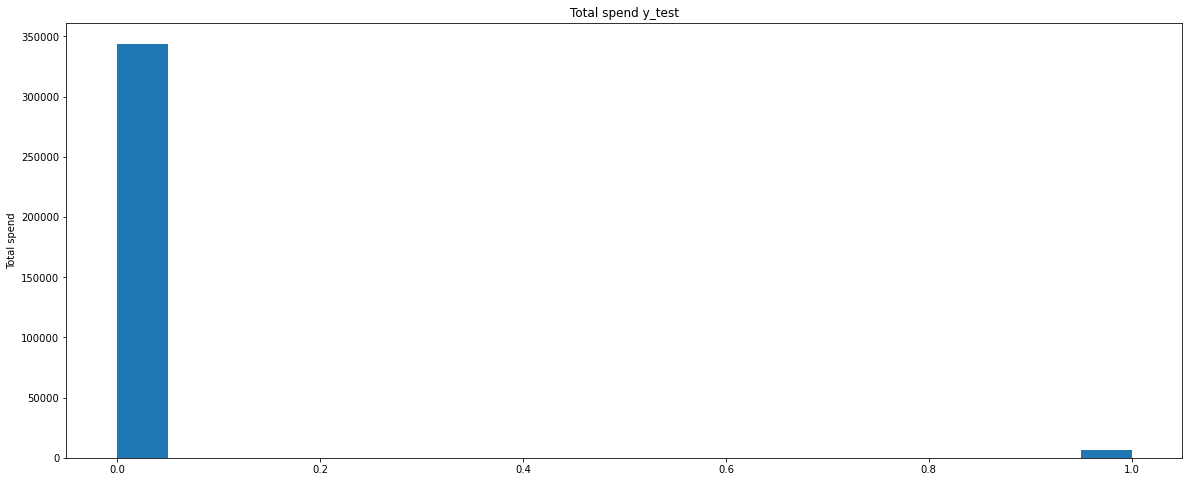

In [28]:
plt.figure(figsize=(20, 8))
#plt.plot(X_train['game_stats_tutorial_complete_time'][:100000])
plt.title('Total spend y_test')
plt.ylabel('Total spend')
plt.hist(y_test, bins=20)

In [29]:
# Very imbalanced data. Mostly (around 98%) with 0 value (does not spend at all)
print((y_train[y_train>0].shape[0] / y_train[y_train==0].shape[0])*100)

1.7776079513631353


In [30]:
# Oversampling, downsampling, PCA, drop categorical columns and drop zero class
if classification_mode:
    if down_sample:
        undersample = RandomUnderSampler(sampling_strategy=down_sample)
        # fit and apply the transform
        X_train, y_train = undersample.fit_resample(X_train, y_train)
        print("Downsampling is done.")

    if up_sample:
        if up_sample == "random_oversample":
            oversample = RandomOverSampler(sampling_strategy="not majority")
        if up_sample == "smote_oversample":
            oversample = SMOTE(sampling_strategy="not majority")
        # fit and apply the transform
        X_train, y_train = oversample.fit_resample(X_train, y_train)
        print("Oversampling is done.")

if drop_categorical_cols:
    try:
        X_train = X_train.drop(columns=categorical_columns, errors='ignore')
        X_test = X_test.drop(columns=categorical_columns, errors='ignore')
        print("Categorical columns dropped.")
    except ValueError:
        print("No categorical columns to drop. Check feature selection removed features.")
        
if PCA_apply:
    pca = PCA(n_components=PCA_apply)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    print("PCA done.")

if drop_zero_calss:
    if n_class <= 2 and classification_mode:
        pass
    else:
        X_train = X_train[y_train != 0]
        y_train = y_train[y_train != 0]
        X_test = X_test[y_test != 0]
        y_test = y_test[y_test != 0]
        print("Zero class removed.")

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
    

Downsampling is done.
Oversampling is done.
X_train shape:  (489400, 21)
y_train shape:  (489400,)
X_test shape:  (350260, 21)
y_test shape:  (350260,)


In [31]:
# how manu values are there in each class
for i in y_train.unique():
    print(f"Class {i}: ", y_train[y_train == i].shape[0])
print(y_train.unique())

Class 0:  244700
Class 1:  244700
[0 1]


In [32]:
def plot_results(y_test, y_pred):
    """
    Plots the results of the model.

    Parameters:
    ----------
    y_test: numpy ndarray
        The actual values of the test set.
    y_pred: numpy ndarray
        The predicted values of the test set.
    """
    plt.figure(figsize=(20, 8))
    # plt.scatter(np.arange(y_test.shape[0]), y_test, label='Actual')
    # plt.scatter(np.arange(y_pred.shape[0]), y_pred, label='Predicted')
    plt.hist(y_test, bins=20, label='Actual')
    plt.hist(y_pred, bins=20, label='Predicted')
    plt.legend()
    plt.title('Predicted vs Actual')
    plt.ylabel('Total spend')
    plt.show()

def regression_repot(y_test, y_pred):
    """
    compute errors for regression and plot results.

    Parameters:
    ----------
    y_test: numpy ndarray
        The actual values of the test set.
    y_pred: numpy ndarray
        The predicted values of the test set.
    """
    y_test_reverse = scaler.inverse_transform(y_test.values.reshape(-1,1))
    y_pred_reverse = scaler.inverse_transform(y_pred.reshape(-1,1))
    print("MSE: ", mean_squared_error(y_test_reverse, y_pred_reverse))
    print("MAE: ", mean_absolute_error(y_test_reverse, y_pred_reverse))
    plot_results(y_test_reverse, y_pred_reverse)

def prediction_reg(reg, X_test, y_test):
    """
    Performs a prediction on the test set for regression.

    Parameters:
    ----------
    reg: sklearn regressor
        The regressor to use.
    X_test: numpy ndarray
        The test set.
    y_test: numpy ndarray
        The actual values of the test set.
        
    Returns:
    ----------
    y_pred: numpy ndarray
        The predicted values of the test set and regression report.
    """
    y_pred = reg.predict(X_test)
    regression_repot(y_test, y_pred)
    
    return y_pred
    

In [33]:
# Save best model for LSTM and Early stopping
class TerminateOnBaseline(Callback):
    """Callback that terminates training when either acc or val_acc reaches a specified baseline
    """
    def __init__(self, monitor='val_loss', baseline=0.001):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = baseline

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get(self.monitor)
        if acc is not None:
            if acc <= self.baseline:
                print('Epoch %d: Reached baseline, terminating training' % (epoch))
                self.model.stop_training = True
save_best = keras.callbacks.ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True)

ML and DL Train and Test

Regression

In [34]:
if regression_mode:
    print("ElasticNetCV")
    reg = ElasticNetCV(cv=5)
    reg.fit(X_train, y_train)
    y_pred = prediction_reg(reg, X_test, y_test)

    print("XGBoost")
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dtest = xgb.DMatrix(data=X_test, label=y_test)
    params = {'subsample': 0.1,
            'colsample_bytree': 0.1,
            'objective': 'reg:linear',
            'eval_metric': 'rmse',
            'max_depth': 50,
            'silent': 1,
            'learning_rate': 0.1,
            'nthread': 4,
            'n_estimators': 3000,
            }
    reg = xgb.train(params, dtrain, 2)
    y_pred = prediction_reg(reg, dtest, y_test)

    print("Linear Regression")
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = prediction_reg(reg, X_test, y_test)

    print("******"*12)
    print("Kernel Ridge")
    reg = KernelRidge(alpha=1.0)
    reg.fit(X_train, y_train)
    y_pred = prediction_reg(reg, X_test, y_test)

    print("******"*12)
    print("All models")
    reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
    models, predictions = reg.fit(X_train, X_test, y_train, y_test)
    print(models)
    print("*******"*12)

In [35]:
#LSTM model
if regression_mode:
    print("LSTM regression")
    number_of_epochs = 5
    batch_size = 128
    validation_split = 0.2
    
    x_train = np.expand_dims(X_train, axis=2)
    x_test = np.expand_dims(X_test, axis=2)

    model = Sequential()
    model.add(LSTM(256, input_shape=(x_train.shape[1],x_train.shape[2]), activation='relu', return_sequences = False))
    model.add(Dense(1))
    model.compile(optimizer='sgd', loss='mse', metrics=['mae'])
    model.summary()
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=number_of_epochs, shuffle=True, verbose=1,
                        validation_split=validation_split,
                        callbacks=[TerminateOnBaseline(monitor='val_loss', baseline=0.0005), save_best]).history

    model = load_model('./model.h5')
    y_pred = prediction_reg(model, x_test, y_test)

Classification

In [36]:
if classification_mode:
    print("QuadraticDiscriminantAnalysis")
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(X_train, y_train)
    y_pred = qda.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    print("******"*12)
    print("KNN")
    if isinstance(y_train, pd.Series):
        y = y_train.values
    else:
        y = y_train
    knn = KNeighborsClassifier(n_neighbors=10).fit(X_train, y.reshape(-1, 1))
    y_pred = knn.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    print("******"*12)
    print("XGboost model classification")
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    model.fit(X_train, y_train)
    XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred <= 0.5, 0, 1)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    print("******"*12)
    print("LSTM model classification")
    # Model configuration
    additional_metrics = ['accuracy']
    batch_size = 128
    loss_function = CategoricalCrossentropy()
    number_of_epochs = 50
    optimizer = Adam()
    validation_split = 0.1
    verbosity_mode = 1
    y_train_cat = tf.keras.utils.to_categorical(y_train)
    y_test_cat = tf.keras.utils.to_categorical(y_test)
    # print(y_train.shape)
    # Define the Keras model
    model = Sequential()
    #model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
    # model.add(Embedding(50000, 8, input_length = X_train.shape[1]))
    #model.add(LSTM(256, return_sequences=True))
    model.add(LSTM(32, activation ='relu'))
    #model.add(Dropout(0.2))
    #model.add(Dense(128, activation='relu'))
    model.add(Dense(y_train_cat.shape[1], activation='softmax'))
    # Compile the model
    model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
    # Train the model
    history = model.fit(np.expand_dims(X_train,2), y_train_cat, batch_size=batch_size,
                epochs=number_of_epochs, verbose=verbosity_mode, validation_split=validation_split, shuffle=True,
                callbacks=[TerminateOnBaseline(monitor='val_loss', baseline=0.0005), save_best]).history
    # Give a summary
    model.summary()
    # Test the model after training
    model = load_model('./model.h5')
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test_cat.argmax(axis=1), y_pred.argmax(axis=1)))
    print(classification_report(y_test_cat.argmax(axis=1), y_pred.argmax(axis=1)))
    
    print("******"*12)
    print("All models")
    clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
    models,predictions = clf.fit(X_train, X_test, y_train, y_test)
    print(models)


QuadraticDiscriminantAnalysis
[[173465 170574]
 [  1125   5096]]
              precision    recall  f1-score   support

           0       0.99      0.50      0.67    344039
           1       0.03      0.82      0.06      6221

    accuracy                           0.51    350260
   macro avg       0.51      0.66      0.36    350260
weighted avg       0.98      0.51      0.66    350260

************************************************************************
KNN
[[268420  75619]
 [  2481   3740]]
              precision    recall  f1-score   support

           0       0.99      0.78      0.87    344039
           1       0.05      0.60      0.09      6221

    accuracy                           0.78    350260
   macro avg       0.52      0.69      0.48    350260
weighted avg       0.97      0.78      0.86    350260

************************************************************************
XGboost model classification
[00:44:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_

  0%|          | 0/29 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.99      0.78      0.87    344039
           1       0.06      0.76      0.11      6221

    accuracy                           0.78    350260
   macro avg       0.53      0.77      0.49    350260
weighted avg       0.98      0.78      0.86    350260

************************************************************************
All models


 10%|█         | 3/29 [04:29<38:57, 89.90s/it]


KeyboardInterrupt: 

Cross-validation and HPO should be considered too for models. 
Unit testing and use more complex models should be considered.

In [ ]:
print(f'Time taken: {time.time() - start} seconds')

Time taken: 1348.1818296909332 seconds
